# Valor real de los inmuebles: optimización de recursos provinciales desde un paradigma progresivo.

## 1. Tareas Preliminares
### I. Importación de librerías

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import os
import folium
import pysal
import geopandas as gpd
%matplotlib inline

E:\Miniconda3\envs\ds37\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


### II. Importación de datos

In [2]:
df = pd.read_excel("datos_tesis.xls")
df

,Price,PriceUS,LotLandSize,ConstructionSize,Bedrooms,Bathrooms,CarParkingLots,District,Latitude,Longitude,PropertyType
0,1700000.0,NaN,420.0,60.00,2.0,1.0,1.0,Santa Lucia,-31.536921,-68.451610,Casas
1,4350000.0,NaN,500.0,151.00,3.0,2.0,3.0,Capital,-31.523386,-68.529153,Casas
2,3000000.0,NaN,270.0,61.32,2.0,1.0,1.0,Rawson,-31.586140,-68.515935,Casas
3,NaN,75000.0,200.0,80.00,2.0,1.0,1.0,Rivadavia,-31.520605,-68.591981,Casas
4,4000000.0,NaN,249.0,146.00,2.0,2.0,1.0,Capital,-31.521341,-68.558553,Casas
...,...,...,...,...,...,...,...,...,...,...,...
889,2800000.0,NaN,480.0,NaN,NaN,NaN,NaN,Santa Lucia,-31.526056,-68.463278,Lotes
890,NaN,20000.0,250.0,NaN,NaN,NaN,NaN,Pocito,-31.651263,-68.578506,Lotes
891,100000.0,NaN,300.0,NaN,NaN,NaN,NaN,Rawson,-31.534150,-68.523472,Lotes
892,180000.0,NaN,300.0,NaN,NaN,NaN,NaN,Pocito,-31.589823,-68.559510,Lotes


In [3]:
df.tail()

,Price,PriceUS,LotLandSize,ConstructionSize,Bedrooms,Bathrooms,CarParkingLots,District,Latitude,Longitude,PropertyType
889,2800000.0,NaN,480.0,NaN,NaN,NaN,NaN,Santa Lucia,-31.526056,-68.463278,Lotes
890,NaN,20000.0,250.0,NaN,NaN,NaN,NaN,Pocito,-31.651263,-68.578506,Lotes
891,100000.0,NaN,300.0,NaN,NaN,NaN,NaN,Rawson,-31.534150,-68.523472,Lotes
892,180000.0,NaN,300.0,NaN,NaN,NaN,NaN,Pocito,-31.589823,-68.559510,Lotes
893,850000.0,NaN,5700.0,NaN,NaN,NaN,NaN,Pocito,-31.586176,-68.580265,Lotes


## III. Construimos las variables necesarias

In [4]:
# convertimos las variables en floats
df['bsqm'] = df['ConstructionSize'].astype(np.float64, errors='ignore')
df['lat'] = df['Latitude'].astype(np.float64)
df['long'] = df['Longitude'].astype(np.float64)


# generacion de variables dummies segun tipo de inmueble
df['house'] = 0
df['lot'] = 0
df['dept'] = 0
df.loc[(df.PropertyType=="Casas"), 'house'] = 1
df.loc[(df.PropertyType=="Lotes"), 'lot'] = 1
df.loc[(df.PropertyType=="Departamentos"), 'dept'] = 1

df['type'] = df['PropertyType']

# generacion de variables dummies segun distrito (departamento)
df['dcap'] = 0 # capital
df['dsta'] = 0 # santa lucia
df['driv'] = 0 # rivadavia
df['draw'] = 0 # rawson
df['dchi'] = 0 # chimbas
df['dpoc'] = 0 # pocito

df.loc[(df.District=="Capital"), 'dcap'] = 1
df.loc[(df.District=="Santa Lucia"), 'dsta'] = 1
df.loc[(df.District=="Rivadavia"), 'driv'] = 1
df.loc[(df.District=="Rawson"), 'draw'] = 1
df.loc[(df.District=="Pocito"), 'dpoc'] = 1
df.loc[(df.District=="Chimbas"), 'dchi'] = 1

# reemplazo de valores erroneos
#df.loc[(df.Bedrooms=='NaN'), 'Bedrooms'] = 0
#df.loc[(df.Bathrooms=='NaN'), 'Bathrooms'] = 0
#df.loc[(df.CarParkingLots=='NaN'), 'CarParkingLots'] = 0

df['Bedrooms'] = df['Bedrooms'].astype(np.float64, errors='ignore')
df['Bathrooms'] = df['Bathrooms'].astype(np.float64, errors='ignore')
df['CarParkingLots'] = df['CarParkingLots'].astype(np.float64, errors='ignore')


# generacion de variables dummies segun cantidad de banos
df['baths'] = df['Bathrooms']
df['bath1'] = 0
df['bath2'] = 0
df['bath3'] = 0
df['bath4'] = 0
df['bath5'] = 0
df.loc[(df.Bathrooms==1), 'bath1'] = 1
df.loc[(df.Bathrooms==2), 'bath2'] = 1
df.loc[(df.Bathrooms==3), 'bath3'] = 1
df.loc[(df.Bathrooms==4), 'bath4'] = 1
df.loc[(df.Bathrooms==5), 'bath5'] = 1

# generacion de variables dummies segun cantidad de dormitorios
df['dorms'] = df['Bedrooms']
df['dorm1'] = 0
df['dorm2'] = 0
df['dorm3'] = 0
df['dorm4'] = 0
df['dorm5'] = 0
df.loc[(df.Bedrooms==1), 'dorm1'] = 1
df.loc[(df.Bedrooms==2), 'dorm2'] = 1
df.loc[(df.Bedrooms==3), 'dorm3'] = 1
df.loc[(df.Bedrooms==4), 'dorm4'] = 1
df.loc[(df.Bedrooms==5), 'dorm5'] = 1

# generacion de variables dummies segun cantidad de cocheras
df['garages'] = df['CarParkingLots']
df['garage1'] = 0
df['garage2'] = 0
df['garage3'] = 0
df['garage4'] = 0
df['garage5'] = 0
df.loc[(df.CarParkingLots==1), 'garage1'] = 1
df.loc[(df.CarParkingLots==2), 'garage2'] = 1
df.loc[(df.CarParkingLots==3), 'garage3'] = 1
df.loc[(df.CarParkingLots==4), 'garage4'] = 1
df.loc[(df.CarParkingLots==5), 'garage5'] = 1

# precios en pesos y unificados
USDxARS = 43

df['PriceArs'] = df['Price']
df['PriceArs'] = df['PriceArs'].fillna(df.PriceUS*USDxARS)

# unificacion m2
df['tsqm'] = df['LotLandSize']

# forzamos variables a float
df['tsqm'] = pd.to_numeric(df.tsqm, errors='coerce').astype(np.float64, errors='ignore')
df['bsqm'] = pd.to_numeric(df.bsqm, errors='coerce').astype(np.float64, errors='ignore')

# Calculamos el cuadrado de estas variables
df['tsqm2'] = df['tsqm'].apply(np.square)
df['bsqm2'] = df['bsqm'].apply(np.square)


# logaritmo natural del precios
#df['p'] = df['PriceArs']
#df['lp'] = df['p'].apply(np.log)
df['lprice'] = df['PriceArs'].apply(np.log)

# ratio de metros construidos
df['b_ratio'] = df['bsqm']/df['tsqm']

df['pm2'] = df['PriceArs']/df['tsqm']

## IV. Filtramos el dataframe a las variables homogeneizadas que nos interesan

In [5]:
df = df.filter(['PriceArs','lprice', 'tsqm', 'tsqm2', 'bsqm', 'bsqm2', 'house', 'dept', 'lot', 'lat', 'long',
                'bath1', 'bath2', 'bath3', 'bath4', 'bath5', 'garages', 'garage1', 'garage2', 'garage3',
                'garage4', 'garage5', 'dorm1', 'dorm2', 'dorm3', 'dorm4', 'dorm5', 'mratio', 'baths', 'dorms', 'p', 'lp',
                'type', 'dcap', 'dsta', 'driv', 'draw', 'dpoc', 'dchi', 'pm2', 'b_ratio', 'District'])

df

,PriceArs,lprice,tsqm,tsqm2,bsqm,bsqm2,house,dept,lot,lat,...,type,dcap,dsta,driv,draw,dpoc,dchi,pm2,b_ratio,District
0,1700000.0,14.346139,420.0,176400.0,60.00,3600.0000,1,0,0,-31.536921,...,Casas,0,1,0,0,0,0,4047.619048,0.142857,Santa Lucia
1,4350000.0,15.285686,500.0,250000.0,151.00,22801.0000,1,0,0,-31.523386,...,Casas,1,0,0,0,0,0,8700.000000,0.302000,Capital
2,3000000.0,14.914123,270.0,72900.0,61.32,3760.1424,1,0,0,-31.586140,...,Casas,0,0,0,1,0,0,11111.111111,0.227111,Rawson
3,3225000.0,14.986444,200.0,40000.0,80.00,6400.0000,1,0,0,-31.520605,...,Casas,0,0,1,0,0,0,16125.000000,0.400000,Rivadavia
4,4000000.0,15.201805,249.0,62001.0,146.00,21316.0000,1,0,0,-31.521341,...,Casas,1,0,0,0,0,0,16064.257028,0.586345,Capital
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2800000.0,14.845130,480.0,230400.0,NaN,NaN,0,0,1,-31.526056,...,Lotes,0,1,0,0,0,0,5833.333333,NaN,Santa Lucia
890,860000.0,13.664688,250.0,62500.0,NaN,NaN,0,0,1,-31.651263,...,Lotes,0,0,0,0,1,0,3440.000000,NaN,Pocito
891,100000.0,11.512925,300.0,90000.0,NaN,NaN,0,0,1,-31.534150,...,Lotes,0,0,0,1,0,0,333.333333,NaN,Rawson
892,180000.0,12.100712,300.0,90000.0,NaN,NaN,0,0,1,-31.589823,...,Lotes,0,0,0,0,1,0,600.000000,NaN,Pocito


## 2. Análisis exploratorio de datos

'Distribución de precios de los inmuebles: Casas en Azul, Departamentos en Naranja y Lotes en Verde'

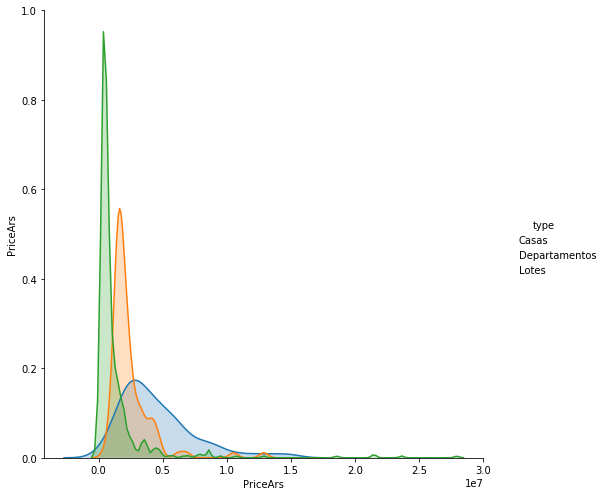

In [6]:
sns.pairplot(df, vars=['PriceArs'], hue='type', height=7, markers='type' );
'Distribución de precios de los inmuebles: \
Casas en Azul, Departamentos en Naranja y Lotes en Verde'

'Distribución del logaritmo de precios de los inmuebles: Casas en Azul, Departamentos en Naranja y Lotes en Verde'

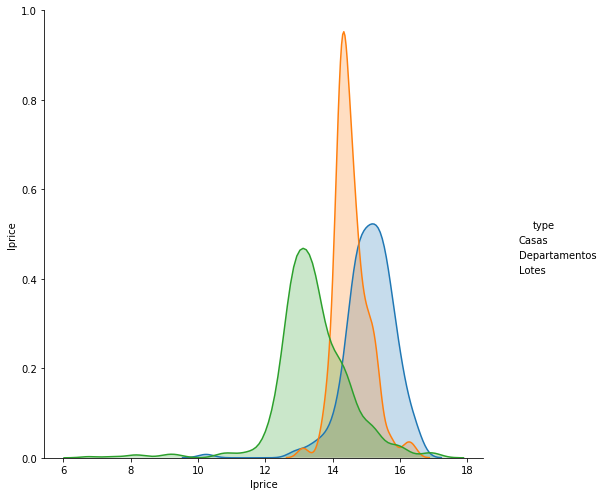

In [7]:
sns.pairplot(df, vars=['lprice'], hue='type', height=7, markers='type' );
'Distribución del logaritmo de precios de los inmuebles: \
Casas en Azul, Departamentos en Naranja y Lotes en Verde'

'Distribución del logaritmo de precios de los inmuebles: Casas en Azul, Departamentos en Naranja y Lotes en Verde'

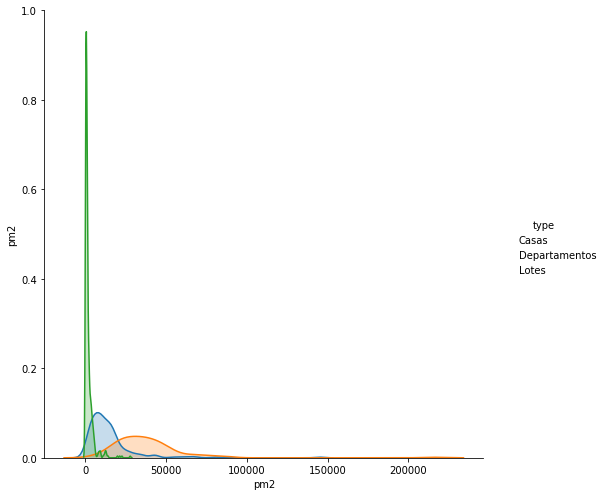

In [8]:
sns.pairplot(df, vars=['pm2'], hue='type', height=7, markers='type' );
'Distribución del logaritmo de precios de los inmuebles: \
Casas en Azul, Departamentos en Naranja y Lotes en Verde'

In [9]:
df.pivot_table('pm2', columns='type', aggfunc=['mean', np.std])

mean                                      std                \
type         Casas Departamentos        Lotes         Casas Departamentos   
pm2   14273.012619  37964.350296  1770.243424  15113.614394  24120.567529   

                   
type        Lotes  
pm2   2732.651577

## 3. Feature Selection
#### I. Modelo lineal inicial para Casas

In [10]:
model1 = smf.ols("lprice ~ tsqm + tsqm2 + bsqm + bsqm2 + dorm1 + dorm2 + dorm3 + dorm4 + dorm5 + bath1 + bath2 + bath3 + bath4 + bath5 + garage1 + garage2 + garage3 + garage4 + garage5 + house + dept + lot ", data=df )
model1_reg = model1.fit()
model1_reg.summary()


E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
E:\Miniconda3\envs\ds37\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
E:\Miniconda3\envs\ds37\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
E:\Miniconda3\envs\ds37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     10.20
Date:                Sun, 08 Sep 2019   Prob (F-statistic):           2.98e-21
Time:                        21:56:37   Log-Likelihood:                -261.23
No. Observations:                 308   AIC:                             558.5
Df Residuals:                     290   BIC:                             625.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6387      0.120     63.804      0.000       7.403       7.874
tsqm           0.0002      0.000      0.409      0.683      -0.001       0.001
tsqm2      -4.469e-08   2.27e-07     -0.197      0.844   -4.91e-07    4.02e-07
bsqm           0.0054      0.002      2.999      0.003       0.002       0.009
bsqm2      -5.523e-06   3.79e-06     -1.458      0.146    -1.3e-05    1.93e-06
dorm1          1.3931      0.100     13.972      0.000       1.197       1.589
dorm2          1.6302      0.082     19.821      0.000       1.468       1.792
dorm3          1.6111      0.073     22.174      0.000       1.468       1.754
dorm4          1.5671      0.104     15.076      0.000       1.363       1.772
dorm5          1.4372      0.170      8.436      0.000       1.102       1.773
bath1          1.2242      0.123      9.925      0.000       0.981       1.467
bath2          1.3850      0.116     11.889      0.000       1.156       1.614
bath3          1.6848      0.150     11.237      0.000       1.390       1.980
bath4          1.3526      0.269      5.023      0.000       0.823       1.883
bath5          1.9920      0.367      5.432      0.000       1.270       2.714
garage1       -0.0387      0.092     -0.423      0.673      -0.219       0.141
garage2        0.2301      0.122      1.890      0.060      -0.010       0.470
garage3        0.0517      0.213      0.243      0.808      -0.367       0.470
garage4        0.4420      0.644      0.687      0.493      -0.825       1.709
garage5             0          0        nan        nan           0           0
house          3.8032      0.102     37.409      0.000       3.603       4.003
dept           3.8355      0.068     56.129      0.000       3.701       3.970
lot                 0          0        nan        nan           0           0
==============================================================================
Omnibus:                      204.985   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5080.149
Skew:                          -2.278   Prob(JB):                         0.00
Kurtosis:                      22.368   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### II. Modelo lineal para Departamentos

In [11]:
model2 = smf.ols("lprice ~ bsqm + dorm1 + dorm2 + dorm3 + dorm4 + dorm5 + bath1 + bath2 + bath3 + bath4 + bath5 + garages + house + dept", data=df )
model2_reg = model2.fit()
model2_reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.333   
Dependent Variable: lprice           AIC:                554.9765
Date:               2019-09-08 21:56 BIC:                599.7377
No. Observations:   308              Log-Likelihood:     -265.49 
Df Model:           11               F-statistic:        14.92   
Df Residuals:       296              Prob (F-statistic): 5.51e-23
R-squared:          0.357            Scale:              0.34158 
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
Intercept   7.7141     0.0962   80.2273   0.0000    7.5249   7.9034
bsqm        0.0032     0.0008    4.0477   0.0001    0.0016   0.0047
dorm1       1.3749     0.0971   14.1628   0.0000    1.1838   1.5659
dorm2       1.6558     0.0795   20.8331   0.0000    1.4994   1.8123
dorm3       1.6787     0.0632   26.5659   0.0000    1.5543   1.8031
dorm4       1.6238     0.0953   17.0389   0.0000    1.4363   1.8114
dorm5       1.3809     0.1631    8.4651   0.0000    1.0598   1.7019
bath1       1.1892     0.1203    9.8857   0.0000    0.9524   1.4259
bath2       1.4062     0.1152   12.2016   0.0000    1.1794   1.6330
bath3       1.6737     0.1500   11.1593   0.0000    1.3785   1.9688
bath4       1.4528     0.2676    5.4287   0.0000    0.9261   1.9795
bath5       1.9923     0.3540    5.6275   0.0000    1.2955   2.6890
garages     0.0765     0.0442    1.7306   0.0846   -0.0105   0.1635
house       3.8744     0.0743   52.1106   0.0000    3.7280   4.0207
dept        3.8398     0.0598   64.1890   0.0000    3.7220   3.9575
-----------------------------------------------------------------
Omnibus:          205.070  Durbin-Watson:     1.908              
Prob(Omnibus):    0.000    Jarque-Bera (JB):  5067.226           
Skew:             -2.280   Prob(JB):          0.000              
Kurtosis:         22.340   Condition No.:     2764874471823864320
=================================================================
* The condition number is large (3e+18). This might indicate
strong multicollinearity or other numerical problems.
"""

In [12]:
df.loc[(df.lot==1)]

,PriceArs,lprice,tsqm,tsqm2,bsqm,bsqm2,house,dept,lot,lat,...,type,dcap,dsta,driv,draw,dpoc,dchi,pm2,b_ratio,District
308,12900.0,9.464983,1.0,1.0,NaN,NaN,0,0,1,-31.532970,...,Lotes,1,0,0,0,0,0,12900.000000,NaN,Capital
309,700000.0,13.458836,800.0,640000.0,NaN,NaN,0,0,1,-31.528727,...,Lotes,0,1,0,0,0,0,875.000000,NaN,Santa Lucia
310,1650000.0,14.316286,1100.0,1210000.0,NaN,NaN,0,0,1,-31.578938,...,Lotes,0,0,0,1,0,0,1500.000000,NaN,Rawson
311,3500000.0,15.068274,1200.0,1440000.0,NaN,NaN,0,0,1,-31.532695,...,Lotes,0,0,1,0,0,0,2916.666667,NaN,Rivadavia
312,690000.0,13.444447,1444.0,2085136.0,NaN,NaN,0,0,1,-31.560180,...,Lotes,0,1,0,0,0,0,477.839335,NaN,Santa Lucia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2800000.0,14.845130,480.0,230400.0,NaN,NaN,0,0,1,-31.526056,...,Lotes,0,1,0,0,0,0,5833.333333,NaN,Santa Lucia
890,860000.0,13.664688,250.0,62500.0,NaN,NaN,0,0,1,-31.651263,...,Lotes,0,0,0,0,1,0,3440.000000,NaN,Pocito
891,100000.0,11.512925,300.0,90000.0,NaN,NaN,0,0,1,-31.534150,...,Lotes,0,0,0,1,0,0,333.333333,NaN,Rawson
892,180000.0,12.100712,300.0,90000.0,NaN,NaN,0,0,1,-31.589823,...,Lotes,0,0,0,0,1,0,600.000000,NaN,Pocito


### III. Modelo lineal para Lotes

In [13]:
model2 = smf.ols("lprice ~ tsqm + tsqm2 + bsqm + dorm1 + dorm2 + dorm3 + dorm4 + dorm5 + bath1 + bath2 + bath3 + bath4 + bath5 + garages + house + dept", data=df.loc[(df.lot==1)] )
model2_reg = model2.fit()
model2_reg.summary2()

ValueError: zero-size array to reduction operation maximum which has no identity

## 4. Modelo modificado
### I. Modelo lineal para Casas

In [ ]:
model1 = smf.ols("lprice ~ tsqm + bsqm + dorm1 + dorm2 + dorm3 + dorm4 + dorm5 + bath1 + bath2 + bath3 + bath4 + bath5 + house + dept + lot + C(District)-1", data=df )
model1_reg = model1.fit()
model1_reg.summary()

### 2. Modelo lineal para departamentos

In [14]:
model2m = smf.ols("dfd.lprice ~  dfd.tsqm + dfd.tsqm2 + dfd.bsqm + dfd.bsqm2 + dfd.dorms + dfd.baths + dfd.garages", data=dfd )
model2m_reg = model2m.fit()
model2m_reg.summary2()

NameError: name 'dfd' is not defined

In [15]:
puntos = df[['long', 'lat']].values
triangulation = sp.spatial.Delaunay(puntos)
tri_2d = sp.spatial.delaunay_plot_2d(triangulation)

AttributeError: module 'scipy.stats' has no attribute 'spatial'

In [16]:
puntos_dept = dfd[['long', 'lat']].values
tri_dept = sp.spatial.Delaunay(puntos_dept)
tri_dept_2d = sp.spatial.delaunay_plot_2d(tri_dept)

NameError: name 'dfd' is not defined

A continuacion para hacer pruebas tomamos 10 observaciones unicamente

In [17]:
# Prueba de matriz de delaunay
dfp = df.iloc[205:235]

points_p = dfp[['long', 'lat']].values
tp = sp.spatial.Delaunay(points_p)
sp.spatial.delaunay_plot_2d(tp)

AttributeError: module 'scipy.stats' has no attribute 'spatial'

NO BORRAR TODAVÍA. QUEDA REVISAR EL CODIGO DE ABAJO QUE PUEDE DAR COMO RESULTADO UN LISTADO DE VECINOS

def find_neighbors(pindex, tp):
    neighbors = list()
    for simplex in tp.vertices:
        if pindex in simplex:
            neighbors.extend([simplex[i] for i in range(len(simplex)) if simplex[i] != pindex])
    #now we just have to strip out all the dulicate indices and return the neighbors list:
    return list(set(neighbors))


# Vecinos Delaunay

El siguiente código busca un elemento del listado de puntos (_pindex_) y averigua cuáles son los vecinos.
Nota: en este ejemplo estamos utilizando únicamente los *deptos* ya que el numero de obs es el menor.

In [ ]:
import scipy.spatial
import numpy
import pylab

pindex = 5
points_d = dfp[['lat', 'long']].values
points_x = dfp['lat'].values
points_y = dfp['long'].values

td = sp.spatial.Delaunay(points_d)
neighbor_indices = td.neighbors[pindex]




pylab.plot(points_x, points_y, 'b.')
pylab.plot(points_x[pindex], points_y[pindex], 'dg')
pylab.plot([points_x[i] for i in neighbor_indices],
           [points_y[i] for i in neighbor_indices], 'ro')    

pylab.show()

### ¿Qué más hace falta?

Necesitamos armar la matriz ponderada NxN de vecinos de Delaunay, donde los vecinos toman valor 1.

# Mapa

El siguiente mapa muestra los inmuebles con el precio relativo por m2 representado por el radio del círculo.
- Casas en color Azul
- Departamentos en color Rojo
- Lotes en color Verde

#### Falta graficar la triangulación de Delaunay para que se vean todos los triángulos que se generan.

In [18]:
mapa = folium.Map(location=[-31.539828,-68.514519], zoom_start=11)

# agregamos casas en color azul
for i in range(0,len(dfh)):
    folium.Circle(
        location = [dfh.iloc[i]['lat'], dfh.iloc[i]['long']],
        popup = dfh.iloc[i]['Type']+', '+str(dfh.iloc[i]['PriceArs'])+', '+str(dfh.iloc[i]['tsqm'])+', '+str(dfh.iloc[i]['bsqm']),
        radius = dfh.iloc[i]['pm2']/500,
        color = 'blue',
        fill = True,
        opacity = 0.89,
        fill_color = 'blue',
        stroke = True,
        weight = 1
        ).add_to(mapa)

# agregamos deptos en color rojo
for i in range(0,len(dfd)):
    folium.Circle(
        location = [dfd.iloc[i]['lat'], dfd.iloc[i]['long']],
        popup = dfd.iloc[i]['Type']+', '+str(dfd.iloc[i]['PriceArs'])+', '+str(dfd.iloc[i]['tsqm'])+', '+str(dfd.iloc[i]['bsqm']),
        radius = dfd.iloc[i]['pm2']/500,
        color = 'red',
        fill = True,
        opacity = 0.89,
        fill_color = 'red',
        stroke = True,
        weight = 1
        ).add_to(mapa)

# agregamos lotes en color verde
for i in range(0,len(dfl)):
    folium.Circle(
        location = [dfl.iloc[i]['lat'], dfl.iloc[i]['long']],
        popup = dfl.iloc[i]['Type']+', '+str(dfl.iloc[i]['PriceArs'])+', '+str(dfl.iloc[i]['tsqm'])+', '+str(dfl.iloc[i]['bsqm']),
        radius = dfl.iloc[i]['pm2']/500,
        color = 'green',
        fill = True,
        opacity = 0.89,
        fill_color = 'green',
        stroke = True,
        weight = 1
        ).add_to(mapa)

mapa

NameError: name 'dfh' is not defined